# **Dependencies**

In [1]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [2]:
!pip uninstall transformer
!pip install git+https://github.com/huggingface/transformers
!pip install mamba-ssm[causal-conv1d]==2.2.4 --no-build-isolation
!pip install rouge-score

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-w43rnmc3
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-w43rnmc3
  Resolved https://github.com/huggingface/transformers to commit cc9997878a5ffefafbb659dbbfc5c7d2a2b78776
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 11.1 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.56.0.dev0-py3-none-any.whl size=12420065 sha256=571dc306707147c4cc2ad953f8c776f0fee0b3be9ad79df89c48f6204c0de8ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-2x6s6vku/wheels/04/a3/f1/b88775f8e1665827525b19ac7590250f1038d947067beba9fb
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.33.1
    Uninstalling huggingface-hub-0.33.1:


# **Data Preprocessing , DataSet and DataLoaders**

In [3]:
import os
import re
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
from transformers import BitsAndBytesConfig
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, get_linear_schedule_with_warmup

2025-08-15 07:46:29.967503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755243990.160257      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755243990.231371      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [5]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH      = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME   = "gpt2"
BATCH_SIZE       = 8
MAX_SEQ_LENGTH   = 512
IMAGE_SIZE       = 224

# Data Split Params (R2Gen-style ratios commonly used in IU-Xray literature)
TRAIN_RATIO      = 0.70  # train
VALID_RATIO      = 0.10  # val
TEST_RATIO       = 0.20  # test
RANDOM_STATE     = 42

assert abs(TRAIN_RATIO + VALID_RATIO + TEST_RATIO - 1.0) < 1e-6, "Ratios must sum to 1."

In [6]:
def clean_text(text):
    if text is None:
        return ""
    text = text.lower().strip()
    text = text.replace('xxxx', '').replace('\n', ' ').replace('\r', ' ')
    text = ' '.join(text.split())
    return text

_PATIENT_ID_RE = re.compile(r'(?:p|patient)?(\d+)', re.IGNORECASE)

def extract_patient_id(xml_path):
    """
    IU-Xray XML filenames are often like 'CXRxxxx.xml' with patient/study info inside.
    The XML has a parentImage id such as 'CXR1234_IM-xxxx-xxxx' and a patient id in text nodes.
    If not explicit, fall back to numeric stem grouping. This keeps patients grouped, preventing leakage.
    """
    # Try to parse from XML PatientID if present; fallback to filename stem numeric cluster
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        pid_node = root.find(".//MedlineCitation/Article/ArticleTitle")  # no patient id here typically
        # IU-Xray provides patient identifiers in DICOM-derived fields sparsely; safer to derive from image ids
        # Find first parentImage id and extract leading integer cluster
        parent = root.find(".//parentImage")
        if parent is not None:
            pid_guess = parent.get('id')  # e.g., 'CXR1000_IM-0001-3001'
            # Derive patient bucket from the numeric group right after CXR
            m = re.search(r'CXR(\d+)', pid_guess or '')
            if m:
                return f"PID_{m.group(1)}"
    except Exception:
        pass
    # Fallback based on filename digits
    stem = os.path.splitext(os.path.basename(xml_path))[0]
    m2 = re.search(r'(\d+)', stem)
    return f"PID_{m2.group(1) if m2 else stem}"

def create_data_manifest(xml_dir, img_dir, tokenizer, max_seq_length=512):
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text   = clean_text(findings_node.text if findings_node is not None else "")

            if not findings_text and not impression_text:
                continue

            full_report = f"<SECTION_FINDINGS> {findings_text} <SECTION_IMPRESSION> {impression_text} {tokenizer.eos_token}"

            patient_id = extract_patient_id(xml_file)

            image_nodes = root.findall(".//parentImage")
            for node in image_nodes:
                image_filename = node.get('id') + ".png"
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    # Treat each image as its own record; same report duplicated
                    manifest.append({
                        'patient_id': patient_id,
                        'image_path': image_path,
                        'report_text': full_report
                    })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
    return manifest

In [7]:
class IUXRayDataset(Dataset):
    def __init__(self, manifest, tokenizer, image_transform, max_seq_length=512):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.transform = image_transform
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_path = item['image_path']

        image = Image.open(image_path).convert('RGB')
        image_tensor = self.transform(image)

        tokenized_report = self.tokenizer(
            report_text,
            truncation=True,
            max_length=self.max_seq_length
        )

        input_ids = tokenized_report['input_ids']
        labels = input_ids.copy()

        return {
            "image": image_tensor,
            "input_ids": torch.tensor(input_ids),
            "labels": torch.tensor(labels),
            "image_path": image_path,
            "patient_id": item['patient_id']
        }

In [8]:
def custom_collate_fn(batch):
    images = [item['image'] for item in batch]
    image_paths = [item['image_path'] for item in batch]
    input_ids_list = [item['input_ids'] for item in batch]
    labels_list    = [item['labels'] for item in batch]

    images = torch.stack(images, dim=0)

    padded_inputs = tokenizer.pad(
        {'input_ids': input_ids_list},
        padding='longest',
        return_tensors='pt'
    )

    padded_labels = tokenizer.pad(
        {'input_ids': labels_list},
        padding='longest',
        return_tensors='pt'
    )['input_ids']

    pad_token_id = tokenizer.pad_token_id
    padded_labels[padded_labels == pad_token_id] = -100

    return {
        'image': images,
        'input_ids': padded_inputs['input_ids'],
        'attention_mask': padded_inputs['attention_mask'],
        'labels': padded_labels,
        'image_path': image_paths
    }

In [9]:
from transformers import GPT2TokenizerFast

special_tokens_dict = {
    'additional_special_tokens': ['<SECTION_FINDINGS>', '<SECTION_IMPRESSION>']
}
tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')
tokenizer.add_special_tokens(special_tokens_dict)
tokenizer.pad_token = tokenizer.eos_token  # Keep this line for consistent padding

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

# **Loaded Data Visualization**

Scanning 3955 XML files to create manifest...
Total per-image records in manifest: 7430

Data successfully split (patient-level, no leakage):
Unique patients total: 3826
Train patients: 2678, Val patients: 383, Test patients: 765
Training samples:   5201
Validation samples: 731
Test samples:       1498

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Batch keys: dict_keys(['image', 'input_ids', 'attention_mask', 'labels', 'image_path'])
Image tensor shape:      torch.Size([8, 3, 224, 224])
Input IDs tensor shape:  torch.Size([8, 73])
Attention mask shape:    torch.Size([8, 73])
Labels tensor shape:     torch.Size([8, 73])


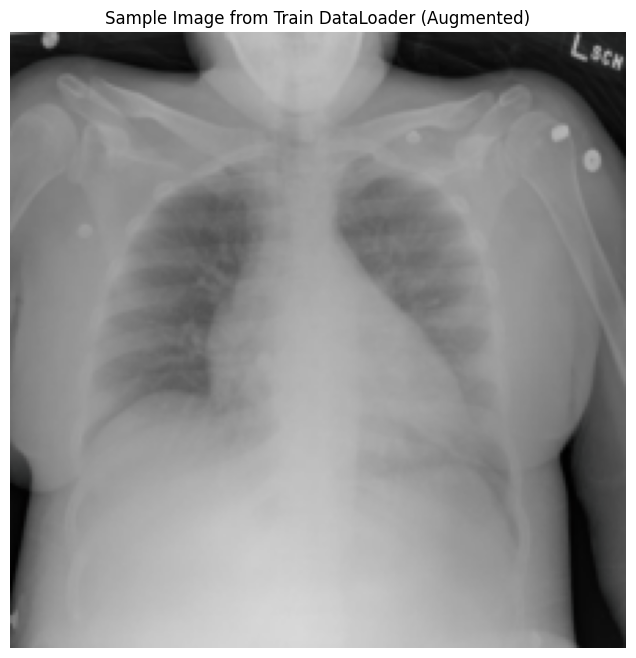


--- Sample Report from the same item (Decoded from Tensors) ---
 the heart and lungs have in the interval. both lungs are clear and expanded. heart and mediastinum normal.  no active disease. 
--------------------------------------------------


In [10]:
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(
    #     degrees=7,
    #     translate=(0.05, 0.05),
    #     scale=(0.95, 1.05),
    #     shear=None
    # ),
    # transforms.ColorJitter(
    #     brightness=0.1,
    #     contrast=0.1,
    #     saturation=0.0,  # avoid unrealistic color shifts
    #     hue=0.0
    # ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# =========================
# Build manifest
# =========================
full_manifest = create_data_manifest(XML_REPORTS_PATH, IMAGES_PATH, tokenizer, max_seq_length=MAX_SEQ_LENGTH)
print(f"Total per-image records in manifest: {len(full_manifest)}")

# =========================
# Patient-level split (R2Gen-style: 70/10/20; no leakage)
# =========================
# Collect unique patients
all_patients = sorted({m['patient_id'] for m in full_manifest})
random.Random(RANDOM_STATE).shuffle(all_patients)

n_patients = len(all_patients)
n_train = int(round(TRAIN_RATIO * n_patients))
n_val   = int(round(VALID_RATIO * n_patients))
# Ensure total equals n_patients
n_test  = n_patients - n_train - n_val

train_patients = set(all_patients[:n_train])
val_patients   = set(all_patients[n_train:n_train+n_val])
test_patients  = set(all_patients[n_train+n_val:])

def filter_by_patients(manifest, keep_patients):
    return [m for m in manifest if m['patient_id'] in keep_patients]

train_manifest = filter_by_patients(full_manifest, train_patients)
val_manifest   = filter_by_patients(full_manifest, val_patients)
test_manifest  = filter_by_patients(full_manifest, test_patients)

print("\nData successfully split (patient-level, no leakage):")
print(f"Unique patients total: {n_patients}")
print(f"Train patients: {len(train_patients)}, Val patients: {len(val_patients)}, Test patients: {len(test_patients)}")
print(f"Training samples:   {len(train_manifest)}")
print(f"Validation samples: {len(val_manifest)}")
print(f"Test samples:       {len(test_manifest)}")

# =========================
# Datasets & DataLoaders
# =========================
train_dataset = IUXRayDataset(train_manifest, tokenizer, train_transform, max_seq_length=MAX_SEQ_LENGTH)
val_dataset   = IUXRayDataset(val_manifest, tokenizer, eval_transform,  max_seq_length=MAX_SEQ_LENGTH)
test_dataset  = IUXRayDataset(test_manifest, tokenizer, eval_transform,  max_seq_length=MAX_SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, collate_fn=custom_collate_fn)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, collate_fn=custom_collate_fn)

print("\nPyTorch DataLoaders are ready!")

# =========================
# Verify one sample batch
# =========================
print("\n--- Verifying a sample batch from the train_loader ---")
sample_batch = next(iter(train_loader))
print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['image'].shape}")
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")
print(f"Labels tensor shape:     {sample_batch['labels'].shape}")

idx_to_show = random.randint(0, sample_batch['image'].size(0) - 1)
input_ids_display = sample_batch['input_ids'][idx_to_show]
report_display = tokenizer.decode(input_ids_display, skip_special_tokens=True)

img_tensor = sample_batch['image'][idx_to_show]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img_display = (img_tensor * std) + mean
img_display = transforms.ToPILImage()(img_display)

plt.figure(figsize=(8, 8))
plt.imshow(img_display)
plt.title("Sample Image from Train DataLoader (Augmented)")
plt.axis('off')
plt.show()

print("\n--- Sample Report from the same item (Decoded from Tensors) ---")
print(report_display)
print("-" * 50)


# **MambaVision**

In [11]:
import torch
import torch.nn as nn
from transformers import AutoModel
from timm.data.transforms_factory import create_transform
import matplotlib.pyplot as plt
import numpy as np
import cv2

class MambaVisionEncoder(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T-1K", device='cuda'):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name, trust_remote_code=True).to(device)
        self.model.eval()
        self.device = device
        self.input_resolution = (3, 224, 224)
        

    def forward(self, image_tensor):
        """
        Input: image_tensor (B, 3, H, W) or list of PIL images
        Output: pooled features (B, 640), raw stage features
        """
        image_tensor = image_tensor.to(self.device)
        with torch.no_grad():
            pooled, features = self.model(image_tensor)
        return pooled, features  # (B, 640), List of [B, C, H, W]

config.json: 0.00B [00:00, ?B/s]

configuration_mambavision.py:   0%|          | 0.00/625 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- configuration_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_mambavision.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/nvidia/MambaVision-T-1K:
- modeling_mambavision.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.11/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


model.safetensors:   0%|          | 0.00/127M [00:00<?, ?B/s]

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Pooled feature shape: torch.Size([8, 640])
Stage 4 feature map shape: torch.Size([8, 640, 7, 7])


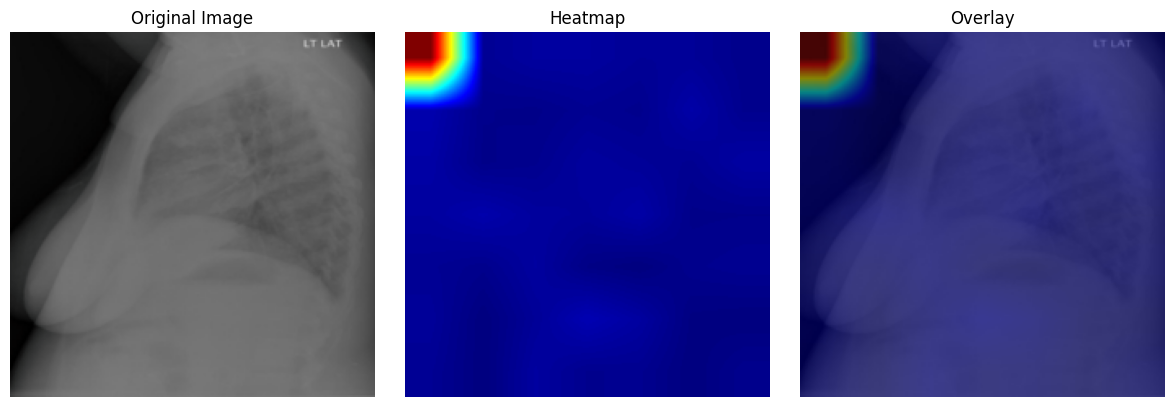

In [12]:

# === Instantiate encoder ===
encoder = MambaVisionEncoder().to('cuda')

# === Load one batch from your dataloader ===
sample_batch = next(iter(train_loader))  # assumes batch contains key 'image'
images = sample_batch['image'].to('cuda')  # (B, 3, 224, 224)

# === Forward pass ===
with torch.no_grad():
    pooled_feats, stage_feats = encoder(images)

print(f"Pooled feature shape: {pooled_feats.shape}")  # (B, 640)
print(f"Stage 4 feature map shape: {stage_feats[3].shape}")  # (B, 640, 7, 7)

# === Visualize one image with heatmap overlay ===
idx = 0
image_tensor = images[idx].cpu()
feature_map = stage_feats[3][idx]  # (640, 7, 7)

# === Generate heatmap ===
activation_map = feature_map.mean(0).cpu().numpy()  # (7, 7)
activation_map = np.maximum(activation_map, 0)
activation_map = (activation_map - activation_map.min()) / (activation_map.max() - activation_map.min() + 1e-8)
activation_map = cv2.resize(activation_map, (224, 224))
heatmap = cv2.applyColorMap(np.uint8(255 * activation_map), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

# === Unnormalize image for visualization ===
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img = (image_tensor * std) + mean
img = torch.clamp(img, 0, 1).permute(1, 2, 0).numpy()
img = np.uint8(255 * img)

# === Overlay heatmap ===
overlay = np.uint8(0.5 * img + 0.5 * heatmap)

# === Display ===
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(heatmap)
plt.title("Heatmap")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

# **Projection layer**

In [13]:
import torch.nn as nn

class VisualProjection(nn.Module):
    def __init__(self, vision_dim=640, gpt2_emb_dim=768):
        super().__init__()
        self.proj = nn.Linear(vision_dim, gpt2_emb_dim)

    def forward(self, vision_feat):
        """
        vision_feat: Tensor of shape (B, vision_dim)
        Returns: Tensor of shape (B, gpt2_emb_dim)
        """
        return self.proj(vision_feat)


In [14]:
encoder = MambaVisionEncoder().to('cuda')

# === Load one batch from your dataloader ===
sample_batch = next(iter(train_loader))  # assumes batch contains key 'image'
images = sample_batch['image'].to('cuda')  # (B, 3, 224, 224)

# === Forward pass ===
with torch.no_grad():
    pooled_feats, stage_feats = encoder(images)  # pooled_feats: (B, 640)

print(f"Pooled feature shape: {pooled_feats.shape}")  # (B, 640)

# === Instantiate Projection Layer ===
gpt2_emb_dim = 768  # or tokenizer/model config n_embd
proj_layer = VisualProjection(vision_dim=pooled_feats.shape[1], gpt2_emb_dim=gpt2_emb_dim).to('cuda')

# === Project visual features ===
with torch.no_grad():
    projected_feats = proj_layer(pooled_feats)  # (B, 768)

print(f"Projected feature shape: {projected_feats.shape}")  # (B, 768)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Pooled feature shape: torch.Size([8, 640])
Projected feature shape: torch.Size([8, 768])


# **CustomGPT2**

In [15]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [16]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [17]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [18]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

# **Main GPT2 Block**

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from types import SimpleNamespace

class CustomGPT2LM(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.wte = nn.Embedding(config.vocab_size, config.embed_dim)
        self.wpe = nn.Embedding(config.seq_len, config.embed_dim)
        self.drop = nn.Dropout(config.emb_dropout)
        self.blocks = nn.ModuleList([GPT2Block(config) for _ in range(config.depth)])
        self.ln_f = nn.LayerNorm(config.embed_dim)
        self.lm_head = nn.Linear(config.embed_dim, config.vocab_size, bias=False)
        
    def resize_token_embeddings(self, new_num_tokens):
        """
        Resize token embeddings and lm_head when vocabulary size changes (e.g., after adding special tokens).
        """
        old_embeddings = self.wte
        old_num_tokens, embedding_dim = old_embeddings.weight.shape
    
        if new_num_tokens == old_num_tokens:
            return self.wte
    
        # 1. New embedding layer
        new_embeddings = nn.Embedding(new_num_tokens, embedding_dim).to(old_embeddings.weight.device)
        nn.init.normal_(new_embeddings.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_num_tokens, new_num_tokens)
        new_embeddings.weight.data[:num_to_copy, :] = old_embeddings.weight.data[:num_to_copy, :]
        self.wte = new_embeddings
    
        # 2. New lm_head layer
        old_lm_head = self.lm_head
        new_lm_head = nn.Linear(embedding_dim, new_num_tokens, bias=False).to(old_lm_head.weight.device)
        nn.init.normal_(new_lm_head.weight, mean=0.0, std=0.02)
        num_to_copy = min(old_lm_head.weight.size(0), new_num_tokens)
        new_lm_head.weight.data[:num_to_copy, :] = old_lm_head.weight.data[:num_to_copy, :]
        self.lm_head = new_lm_head
    
        return self.wte


    def forward(self, input_ids, encoder_hidden_states=None, attention_mask=None, labels=None):
        b, t = input_ids.size()
        device = input_ids.device
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0).expand(b, t)
        x = self.wte(input_ids) + self.wpe(pos)
        x = self.drop(x)

        for block in self.blocks:
            x = block(x, encoder_hidden_states)

        x = self.ln_f(x)
        logits = self.lm_head(x)

        if labels is not None:
            shift_logits = logits[:, :-1, :].contiguous()
            shift_labels = labels[:, 1:].contiguous()

            loss = F.cross_entropy(
                shift_logits.view(-1, shift_logits.size(-1)),
                shift_labels.view(-1),
                ignore_index=-100 # Change to your tokenizer's pad_token_id if it's not 0!
            )
            return SimpleNamespace(loss=loss, logits=logits)
        else:
            return SimpleNamespace(logits=logits)


# **Main Block**

In [20]:
import torch
import torch.nn as nn

class VisionLanguageWrapper(nn.Module):
    def __init__(self, vision_encoder, proj_layer, custom_gpt2):
        super().__init__()
        self.vision_encoder = vision_encoder    # MambaVisionEncoder
        self.proj_layer = proj_layer            # VisualProjection
        self.gpt2 = custom_gpt2                 # Your custom GPT-2, built from GPT2Block

    def forward(self, images, input_ids, attention_mask=None, labels=None):
        # 1. Vision feature extraction
        pooled_feats, _ = self.vision_encoder(images)           # (B, vision_dim)
        visual_emb = self.proj_layer(pooled_feats).unsqueeze(1) # (B, 1, gpt2_emb_dim)

        # 2. Pass to your custom GPT-2 model as cross-attention memory
        #    Assumes that your model's forward signature matches this usage
        outputs = self.gpt2(
            input_ids=input_ids,
            attention_mask=attention_mask,
            encoder_hidden_states=visual_emb,
            labels=labels
        )
        return outputs  # outputs can include logits, loss, etc.
    def freeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = False

    def unfreeze_vision_encoder(self):
        for param in self.vision_encoder.parameters():
            param.requires_grad = True

    def freeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = False

    def unfreeze_text_decoder(self):
        for param in self.gpt2.parameters():
            param.requires_grad = True

    def freeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = False

    def unfreeze_projection(self):
        for param in self.proj_layer.parameters():
            param.requires_grad = True

    def print_trainable_parameters(self):
        total = sum(p.numel() for p in self.parameters())
        trainable = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f'Trainable params: {trainable:,} / {total:,}')

    def freeze_all_base_weights(self):
        # Freeze all base modules
        self.freeze_vision_encoder()
        self.freeze_projection()
        self.freeze_text_decoder()

    def enable_only_lora_and_optional_proj_bias(self, enable_proj_bias=True):
        # Enable only LoRA weights (names contain 'lora_')
        for n, p in self.named_parameters():
            if 'lora_' in n:
                p.requires_grad = True
            elif enable_proj_bias and ('proj_layer' in n and 'base.bias' in n):
                p.requires_grad = True
            else:
                # everything else off
                p.requires_grad = False

    def enable_last_stage_vision(self, patterns=None):
        # Unfreeze selected vision stage params by name pattern
        model = self.vision_encoder.model
        pats = patterns if patterns is not None else LAST_STAGE_PATTERNS
        found = 0
        for n, p in model.named_parameters():
            if any(pat in n for pat in pats):
                p.requires_grad = True
                found += 1
        if found == 0:
            print("Warning: No vision params enabled by patterns. Adjust LAST_STAGE_PATTERNS after printing names.")

    @classmethod
    def from_pretrained(cls, vision_encoder, proj_layer, gpt2_config, custom_gpt2_class):
        """
        - vision_encoder: your vision encoder instance
        - proj_layer: your projection layer instance
        - gpt2_config: config for your custom GPT2 (define embed size etc.)
        - custom_gpt2_class: pass your custom GPT2 model class (e.g., MyCustomGPT2)
        """
        # Instantiate custom GPT-2 model
        custom_gpt2 = custom_gpt2_class(gpt2_config)
        custom_gpt2.resize_token_embeddings(len(tokenizer))
        # Load HuggingFace GPT-2 weights into your custom model
        from transformers import GPT2LMHeadModel
        hf_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")
        hf_sd = hf_gpt2.state_dict()
        custom_sd = custom_gpt2.state_dict()

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        ignore_matches = ["cross_attn.", "ln_3"]  # keys absent/present only in your custom version

        for k in hf_sd.keys():
            if any(match in k for match in ignore_matches):
                continue
            if k not in custom_sd:
                continue
            # Transpose if needed
            if any(k.endswith(w) for w in transposed):
                if hf_sd[k].shape[::-1] == custom_sd[k].shape:
                    with torch.no_grad():
                        custom_sd[k].copy_(hf_sd[k].t())
            elif hf_sd[k].shape == custom_sd[k].shape:
                with torch.no_grad():
                    custom_sd[k].copy_(hf_sd[k])
        custom_gpt2.load_state_dict(custom_sd, strict=False)
        

        return cls(vision_encoder, proj_layer, custom_gpt2)


In [21]:
class LoRALinear(nn.Module):
    def __init__(self, base_linear: nn.Linear, r: int = 8, alpha: int = 16, dropout: float = 0.0):
        super().__init__()
        self.base = base_linear
        self.r = r
        self.alpha = alpha
        self.scaling = alpha / r if r > 0 else 1.0
        self.enable_lora = (r > 0)
        if self.enable_lora:
            self.lora_A = nn.Linear(self.base.in_features, r, bias=False)
            self.lora_B = nn.Linear(r, self.base.out_features, bias=False)
            nn.init.kaiming_uniform_(self.lora_A.weight, a=5**0.5)
            nn.init.zeros_(self.lora_B.weight)
        self.dropout = nn.Dropout(dropout)
        # Freeze base
        for p in self.base.parameters():
            p.requires_grad = False

    def forward(self, x):
        out = self.base(x)
        if self.enable_lora:
            out = out + self.lora_B(self.lora_A(self.dropout(x))) * self.scaling
        return out


def apply_lora_to_gpt2(custom_gpt2, r=8, alpha=16, dropout=0.05, mlp=True, cross_attn=True):
    for blk in custom_gpt2.blocks:
        # Self-attn
        blk.attn.c_attn = LoRALinear(blk.attn.c_attn, r=r, alpha=alpha, dropout=dropout)
        blk.attn.c_proj = LoRALinear(blk.attn.c_proj, r=r, alpha=alpha, dropout=dropout)
        # Cross-attn
        if cross_attn:
            blk.cross_attn.q = LoRALinear(blk.cross_attn.q, r=r, alpha=alpha, dropout=dropout)
            blk.cross_attn.k = LoRALinear(blk.cross_attn.k, r=r, alpha=alpha, dropout=dropout)
            blk.cross_attn.v = LoRALinear(blk.cross_attn.v, r=r, alpha=alpha, dropout=dropout)
            blk.cross_attn.c_proj = LoRALinear(blk.cross_attn.c_proj, r=r, alpha=alpha, dropout=dropout)
        # MLP
        if mlp:
            blk.mlp.c_fc   = LoRALinear(blk.mlp.c_fc,   r=r, alpha=alpha, dropout=dropout)
            blk.mlp.c_proj = LoRALinear(blk.mlp.c_proj, r=r, alpha=alpha, dropout=dropout)
    return custom_gpt2


def apply_lora_to_projection(proj_layer, r=4, alpha=8, dropout=0.0):
    proj_layer.proj = LoRALinear(proj_layer.proj, r=r, alpha=alpha, dropout=dropout)
    return proj_layer


In [22]:
# ===== Selective unfreezing helpers for MambaVision =====

def set_requires_grad(module, requires_grad: bool):
    for p in module.parameters():
        p.requires_grad = requires_grad

# Inspect names once to tune patterns
# for n,_ in vision_encoder.model.named_parameters():
#     print(n)

# Adjust these based on printed names from your MambaVision model
LAST_STAGE_PATTERNS = [
    # Example placeholders; replace with your model’s actual final block/stage identifiers.
    # e.g., 'layers.23', 'stages.3', 'blocks.47', 'encoder.layers.23'
    # Start with a broad suffix if unknown:
    'layers.23', 'stages.3', 'blocks.23'
]

def select_mambavision_last_stage_params(mamba_model):
    selected = []
    for n, p in mamba_model.named_parameters():
        if any(pat in n for pat in LAST_STAGE_PATTERNS):
            selected.append(p)
    return selected


# **Trainer Class**

In [23]:
import os
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import gc
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import re

class EarlyStopping:
    """
    Early stop on validation perplexity (lower is better).
    Tracks best value and counts epochs without improvement beyond min_delta.
    """
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best = np.inf
        self.num_bad_epochs = 0
        self.should_stop = False

    def step(self, current):
        # improvement if drop >= min_delta
        if (self.best - current) >= self.min_delta:
            self.best = current
            self.num_bad_epochs = 0
            return True  # improved
        else:
            self.num_bad_epochs += 1
            if self.num_bad_epochs >= self.patience:
                self.should_stop = True
            return False  # no improvement


class Trainer:
    def __init__(self, vl_model, tokenizer, train_config, dls,optim=None, sched=None):
        """
        vl_model: VisionLanguageWrapper instance (integrates vision encoder, projection, custom GPT2)
        tokenizer: tokenizer with eos_token_id and special tokens added
        train_config: config with fields listed above
        dls: (train_dataloader, val_dataloader)
        """
        self.vl_model = vl_model.to(train_config.device)
        self.tokenizer = tokenizer
        self.train_config = train_config
        self.device = train_config.device

        self.train_dl, self.val_dl = dls
        steps_per_epoch = len(self.train_dl)
        assert steps_per_epoch > 0, "Empty train dataloader."

        self.scaler = torch.cuda.amp.GradScaler()

        # Optimizer
        if optim is None:
            self.optim = torch.optim.Adam(
                filter(lambda p: p.requires_grad, self.vl_model.parameters()),
                lr=train_config.lr / 25.
            )
        else:
            self.optim = optim

        # Scheduler
        if sched is None:
            if getattr(train_config, "scheduler", "onecycle").lower() == "cosine":
                self.sched = torch.optim.lr_scheduler.CosineAnnealingLR(
                    self.optim, T_max=train_config.epochs * steps_per_epoch
                )
                self._scheduler_step_each_batch = True
            else:
                self.sched = torch.optim.lr_scheduler.OneCycleLR(
                    self.optim,
                    max_lr=train_config.lr,
                    epochs=train_config.epochs,
                    steps_per_epoch=steps_per_epoch
                )
                self._scheduler_step_each_batch = True
        else:
            self.sched = sched
            self._scheduler_step_each_batch = True

        # Metric store
        self.metrics = pd.DataFrame()
        self.metrics[['train_loss', 'train_perplexity', 'val_loss', 'val_perplexity']] = None

        # Early stopping
        self.early = EarlyStopping(
            patience=getattr(train_config, "patience", 5),
            min_delta=getattr(train_config, "min_delta", 0.0)
        )

        # EMA for smoother logging
        self._ema_train_loss = None
        self._ema_alpha = 0.1

        # Gradient accumulation
        self.accumulation_steps = max(1, getattr(train_config, "accumulation_steps", 1))

        # Create save dir
        self.train_config.model_path.mkdir(parents=True, exist_ok=True)

    def _update_ema(self, loss_value):
        if self._ema_train_loss is None:
            self._ema_train_loss = loss_value
        else:
            self._ema_train_loss = (1 - self._ema_alpha) * self._ema_train_loss + self._ema_alpha * loss_value

    def save_model(self, filename='vl_model.pt'):
        path = self.train_config.model_path / filename
        sd = self.vl_model.state_dict()
        torch.save(sd, path)
        return path

    def load_best_model(self):
        sd = torch.load(self.train_config.model_path / 'vl_model.pt', map_location=self.device)
        self.vl_model.load_state_dict(sd)

    def load_model_from_path(self, checkpoint_path):
        sd = torch.load(checkpoint_path, map_location=self.device)
        self.vl_model.load_state_dict(sd)

    def _forward_compute_loss(self, batch):
        images = batch['image'].to(self.device, non_blocking=True)
        input_ids = batch['input_ids'].to(self.device, non_blocking=True)
        labels = batch['labels'].to(self.device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(self.device, non_blocking=True)

        with torch.cuda.amp.autocast():
            outputs = self.vl_model(images, input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss if hasattr(outputs, "loss") else outputs
        return loss

    def train_one_epoch(self, epoch):
        self.vl_model.train()
        running_loss = 0.0
        total_batches = len(self.train_dl)

        self.optim.zero_grad(set_to_none=True)

        for batch_idx, batch in enumerate(self.train_dl):
            loss = self._forward_compute_loss(batch)
            loss_value = loss.item()

            # scale by accumulation
            loss = loss / self.accumulation_steps

            self.scaler.scale(loss).backward()

            # optimizer step on accumulation boundary
            if (batch_idx + 1) % self.accumulation_steps == 0:
                # gradient clipping
                if getattr(self.train_config, "clip_grad_norm", None) is not None:
                    self.scaler.unscale_(self.optim)
                    torch.nn.utils.clip_grad_norm_(
                        self.vl_model.parameters(),
                        max_norm=self.train_config.clip_grad_norm
                    )

                self.scaler.step(self.optim)
                self.scaler.update()
                self.optim.zero_grad(set_to_none=True)

            # scheduler step each batch if configured
            if self._scheduler_step_each_batch:
                self.sched.step()

            running_loss += loss_value
            self._update_ema(loss_value)

            # Optional NaN/Inf guard
            if not np.isfinite(loss_value):
                print(f"Warning: non-finite loss at epoch {epoch} batch {batch_idx}: {loss_value}")
                self.optim.zero_grad(set_to_none=True)

            # free batch tensors soon
            del batch, loss

        train_loss = running_loss / total_batches
        train_pxp = float(np.exp(min(train_loss, 20)))  # clamp for numeric stability
        self.metrics.loc[epoch, ['train_loss', 'train_perplexity']] = (train_loss, train_pxp)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Perplexity: {train_pxp:.4f} | EMA Loss: {self._ema_train_loss:.4f}")

    @torch.no_grad()
    def valid_one_epoch(self, epoch):
        self.vl_model.eval()
        running_loss = 0.0
        total_batches = len(self.val_dl)

        for batch_idx, batch in enumerate(self.val_dl):
            loss = self._forward_compute_loss(batch)
            running_loss += loss.item()
            del batch, loss

        val_loss = running_loss / max(1, total_batches)
        val_pxp = float(np.exp(min(val_loss, 20)))
        self.metrics.loc[epoch, ['val_loss', 'val_perplexity']] = (val_loss, val_pxp)
        print(f"Epoch {epoch+1} | Valid Loss: {val_loss:.4f} | Perplexity: {val_pxp:.4f}")
        return val_pxp

    def clean(self):
        gc.collect()
        torch.cuda.empty_cache()

    def fit(self, unfreeze_schedule):
        # Sort by epoch, pop next step as needed
        unfreeze_schedule = sorted(unfreeze_schedule, key=lambda x: x[0])
        next_unfreeze = unfreeze_schedule.pop(0) if unfreeze_schedule else None

        best_pxp = np.inf
        best_epoch = -1

        for epoch in tqdm(range(self.train_config.epochs), desc="Training"):
            # If at scheduled epoch, unfreeze requested vision stages and rebuild optimizer
            if next_unfreeze and epoch == next_unfreeze:
                patterns, lr_mult = next_unfreeze[1], next_unfreeze[2]
                print(f"\n== Unfreezing patterns {patterns} at epoch {epoch} (vision LR={self.train_config.lr * lr_mult}) ==")
                self.vl_model.enable_last_stage_vision(patterns)
                for n,p in self.vl_model.named_parameters():
                    if 'lora_' in n:
                        p.requires_grad = True
                # Rebuild optimizer with updated vision group
                params_lora = []
                params_vision = []
                params_other = []
                for n, p in self.vl_model.named_parameters():
                    if not p.requires_grad:
                        continue
                    if 'lora_' in n:
                        params_lora.append(p)
                    elif 'vision_encoder' in n:
                        params_vision.append(p)
                    else:
                        params_other.append(p)
                param_groups = []
                if params_lora:
                    param_groups.append({'params': params_lora, 'lr': self.train_config.lr, 'weight_decay': 0.01})
                if params_vision:
                    param_groups.append({'params': params_vision, 'lr': self.train_config.lr * lr_mult, 'weight_decay': 0.01})
                if params_other:
                    param_groups.append({'params': params_other, 'lr': self.train_config.lr * 0.5, 'weight_decay': 0.01})
                self.optim = torch.optim.Adam(param_groups)
                # Re-init scheduler if needed (OneCycleLR in particular)
                self.sched = torch.optim.lr_scheduler.OneCycleLR(
                    self.optim,
                    max_lr=self.train_config.lr,  # still max for LoRA group
                    epochs=self.train_config.epochs,
                    steps_per_epoch=len(self.train_dl)
                )
                next_unfreeze = unfreeze_schedule.pop(0) if unfreeze_schedule else None

            # Usual fit logic
            self.train_one_epoch(epoch)
            self.clean()
            val_pxp = self.valid_one_epoch(epoch)
            self.clean()

            improved = self.early.step(val_pxp)

            if improved or val_pxp < best_pxp:
                best_pxp = val_pxp
                best_epoch = epoch
                print('Saving best model...')
                self.save_model('vl_model.pt')

            if self.early.should_stop:
                print(f"Early stopping at epoch {epoch+1} (best at epoch {best_epoch+1}, PPL={best_pxp:.4f}).")
                break

        return {
            'best_perplexity': best_pxp,
            'best_epoch': best_epoch
        }


    def plot_loss_and_perplexity(self):
        if self.metrics is None or self.metrics.empty:
            print("No metrics to plot yet.")
            return
        epochs = range(1, len(self.metrics) + 1)
        plt.figure(figsize=(12, 5))

        # Loss
        plt.subplot(1, 2, 1)
        plt.plot(epochs, self.metrics['train_loss'], label='Train Loss')
        plt.plot(epochs, self.metrics['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs Epochs')
        plt.legend()

        # Perplexity
        plt.subplot(1, 2, 2)
        plt.plot(epochs, self.metrics['train_perplexity'], label='Train Perplexity')
        plt.plot(epochs, self.metrics['val_perplexity'], label='Validation Perplexity')
        plt.xlabel('Epoch')
        plt.ylabel('Perplexity')
        plt.title('Perplexity vs Epochs')
        plt.legend()

        plt.tight_layout()
        plt.show()

    @staticmethod
    def clean_and_format_report(generated_report: str) -> str:
        rep = generated_report.replace('<SECTION_FINDINGS>', '\nFindings:').replace('<SECTION_IMPRESSION>', '\nImpression:')
        patterns = {k: re.compile(rf'{k}:(.*?)((?=\n[a-zA-Z]+:)|$)', re.DOTALL) for k in ['Findings', 'Impression']}
        sections = {k: (patterns[k].search(rep).group(1).strip() if patterns[k].search(rep) else "") for k in patterns}
        for k in sections:
            lines = []
            for line in re.split(r'(?<=\.)\s+', sections[k]):
                if line and line not in lines:
                    lines.append(line)
            sections[k] = " ".join(lines).strip()
        report = f"Findings: {sections['Findings']}\nImpression: {sections['Impression']}"
        return report

    @torch.no_grad()
    def robust_generate_radiology_report(
        self,
        image_input,
        max_tokens=120,
        temperature=1.0,
        temperature_range=None,
        deterministic=False,
        show_image=False,
    ):
        model = self.vl_model
        tokenizer = self.tokenizer
        device = self.device

        model.eval()

        if isinstance(image_input, (str, bytes, os.PathLike)):
            image = Image.open(image_input).convert('RGB')
        elif isinstance(image_input, Image.Image):
            image = image_input.convert('RGB')
        else:
            raise ValueError("image_input should be a PIL.Image or path string.")

        if show_image:
            plt.imshow(image)
            plt.axis('off')
            plt.show()

        if hasattr(self, 'gen_tfms'):
            img_np = np.array(image)
            img_pp = self.gen_tfms(image=img_np)['image']
        else:
            from torchvision import transforms
            transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
            ])
            img_pp = transform(image)
        img_pp = img_pp.unsqueeze(0).to(device)

        section_token = "<SECTION_FINDINGS>"
        section_token_id = tokenizer.convert_tokens_to_ids(section_token)
        sequence = torch.tensor([[section_token_id]], dtype=torch.long, device=device)

        if temperature_range is not None and not deterministic:
            temperature = np.random.uniform(*temperature_range)

        for _ in range(max_tokens):
            pooled_feats, _ = model.vision_encoder(img_pp)
            visual_emb = model.proj_layer(pooled_feats).unsqueeze(1)
            out = model.gpt2(sequence, encoder_hidden_states=visual_emb).logits
            logits = out[:, -1, :] / max(1e-5, temperature)
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.argmax(probs, dim=-1, keepdim=True) if deterministic else torch.multinomial(probs, num_samples=1)
            sequence = torch.cat([sequence, next_token], dim=1)
            if next_token.item() == tokenizer.eos_token_id:
                break

        report = tokenizer.decode(sequence[0].tolist(), skip_special_tokens=False)
        final_report = self.clean_and_format_report(report)
        return final_report


In [24]:
from types import SimpleNamespace
from pathlib import Path

# Model-related configuration (for VisionLanguageWrapper and custom GPT-2)
model_config = SimpleNamespace(
    vocab_size = 50_257,         # GPT-2 vocabulary size
    embed_dim = 768,             # Embedding dimension for GPT-2
    num_heads = 12,              # Number of attention heads
    seq_len = 1024,              # Maximum sequence length (tokens)
    depth = 12,                  # Number of transformer layers (blocks)
    attention_dropout = 0.1,     # Dropout for attention layers
    residual_dropout = 0.1,      # Dropout on residual connections
    mlp_ratio = 4,               # FFN hidden size = embed_dim * mlp_ratio
    mlp_dropout = 0.1,           # Dropout for MLP/FFN sublayer
    emb_dropout = 0.1,           # Dropout on embeddings
    vision_dim = 640,            # Output dim of MambaVision encoder's pooled features
    gpt2_emb_dim = 768,          # Input/output dim of GPT-2 embeddings/projection
)

# Training-related configuration
train_config = SimpleNamespace(
    epochs = 100,
    freeze_epochs_gpt = 3,       # Unfreeze GPT-2 at epoch 1
    freeze_epochs_all = 5,       # Unfreeze vision encoder/proj at epoch 2
    lr = 5e-4,
    device = 'cuda',
    model_path = Path('vl_captioner'),   # Output directory for checkpoints
    batch_size = 8,
    patience=3,
    min_delta= 0.0,
    clip_grad_norm = 1.0,
    accumulation_steps = 1, # >1 enables grad accumulation
    checkpoint_every = 2 ,
    scheduler='onecycle'
)


In [25]:

# Assume you have already defined MambaVisionEncoder, VisualProjection, and your custom GPT-2 model class (e.g., CustomGPT2Model)
vision_encoder = MambaVisionEncoder().to(train_config.device)
proj_layer = VisualProjection(
    vision_dim=model_config.vision_dim,
    gpt2_emb_dim=model_config.gpt2_emb_dim
).to(train_config.device)

# Build VisionLanguageWrapper using your from_pretrained logic
vl_model = VisionLanguageWrapper.from_pretrained(
    vision_encoder,
    proj_layer,
    model_config,
    CustomGPT2LM
).to(train_config.device)

# # --- Trainer ---
# # Assume you already have train_dataloader and val_dataloader prepared as PyTorch DataLoader instances
# trainer = Trainer(
#     vl_model,                      # your VisionLanguageWrapper instance
#     tokenizer,                     # your GPT-2 tokenizer
#     train_config,                  # your training config (SimpleNamespace)
#     (train_loader, val_loader)  # tuple of your dataloaders
# )


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [26]:
UNFREEZE_SCHEDULE = [
    (4, ['layers.23'], 0.10),
    (7, ['layers.22'], 0.06),
    (10, ['layers.21'], 0.04),
]

In [27]:
# Initialization as before
vl_model.freeze_all_base_weights()
apply_lora_to_gpt2(vl_model.gpt2, r=8, alpha=16, dropout=0.05, mlp=True, cross_attn=True)
apply_lora_to_projection(vl_model.proj_layer, r=4, alpha=8, dropout=0.0)
vl_model.enable_only_lora_and_optional_proj_bias(enable_proj_bias=True)

# Build Trainer (acts as Phase A optimizer at start)
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, vl_model.parameters()),
    lr=train_config.lr, weight_decay=0.01
)
trainer = Trainer(
    vl_model, tokenizer, train_config, (train_loader, val_loader), optim=optimizer, sched=None
)



/tmp/ipykernel_19/632296851.py:54: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [28]:
vl_model.print_trainable_parameters()

Trainable params: 1,775,872 / 225,468,744


In [29]:
trainer.fit(UNFREEZE_SCHEDULE)

Training:   0%|          | 0/100 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Train Loss: 9.4584 | Perplexity: 12815.1280 | EMA Loss: 8.8861


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 | Valid Loss: 8.8821 | Perplexity: 7202.1965
Saving best model...


Training:   1%|          | 1/100 [02:53<4:45:28, 173.01s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 | Train Loss: 8.6220 | Perplexity: 5552.7328 | EMA Loss: 8.3913


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 2 | Valid Loss: 8.2380 | Perplexity: 3782.0928
Saving best model...


Training:   2%|▏         | 2/100 [05:42<4:39:34, 171.17s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 | Train Loss: 7.9368 | Perplexity: 2798.4520 | EMA Loss: 7.4490


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 3 | Valid Loss: 7.3922 | Perplexity: 1623.2935
Saving best model...


Training:   3%|▎         | 3/100 [08:32<4:35:46, 170.58s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 | Train Loss: 7.1716 | Perplexity: 1301.9707 | EMA Loss: 6.8889


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 4 | Valid Loss: 6.6218 | Perplexity: 751.2824
Saving best model...


Training:   4%|▍         | 4/100 [11:23<4:32:42, 170.44s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 | Train Loss: 6.6778 | Perplexity: 794.5468 | EMA Loss: 6.4524


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 5 | Valid Loss: 6.2516 | Perplexity: 518.8660
Saving best model...


Training:   5%|▌         | 5/100 [14:13<4:29:52, 170.44s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 | Train Loss: 6.4266 | Perplexity: 618.0649 | EMA Loss: 6.3184


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 6 | Valid Loss: 6.0358 | Perplexity: 418.1258
Saving best model...


Training:   6%|▌         | 6/100 [17:02<4:26:31, 170.13s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 | Train Loss: 6.3181 | Perplexity: 554.5247 | EMA Loss: 5.9752


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 7 | Valid Loss: 5.9645 | Perplexity: 389.3581
Saving best model...


Training:   7%|▋         | 7/100 [19:52<4:23:09, 169.78s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 | Train Loss: 6.2767 | Perplexity: 532.0469 | EMA Loss: 6.2204


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 8 | Valid Loss: 5.9339 | Perplexity: 377.6320
Saving best model...


Training:   8%|▊         | 8/100 [22:41<4:20:19, 169.78s/it]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 9 | Train Loss: 6.2946 | Perplexity: 541.6390 | EMA Loss: 6.5548


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:   9%|▉         | 9/100 [25:29<4:16:28, 169.11s/it]

Epoch 9 | Valid Loss: 5.9402 | Perplexity: 380.0241


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 10 | Train Loss: 6.3180 | Perplexity: 554.4825 | EMA Loss: 6.6143


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:  10%|█         | 10/100 [28:17<4:12:58, 168.65s/it]

Epoch 10 | Valid Loss: 5.9596 | Perplexity: 387.4514


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 11 | Train Loss: 6.3437 | Perplexity: 568.8755 | EMA Loss: 6.1458


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/tmp/ipykernel_19/632296851.py:130: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Training:  10%|█         | 10/100 [31:04<4:39:42, 186.47s/it]

Epoch 11 | Valid Loss: 5.9749 | Perplexity: 393.4321
Early stopping at epoch 11 (best at epoch 8, PPL=377.6320).


{'best_perplexity': 377.6319763954995, 'best_epoch': 7}

# **Loading Trained Model**

In [30]:
trainer.load_best_model()

In [31]:
#trainer.load_model_from_path("/kaggle/input/mambavisionv1/vl_model-2.pt")

# **Report Genearation**

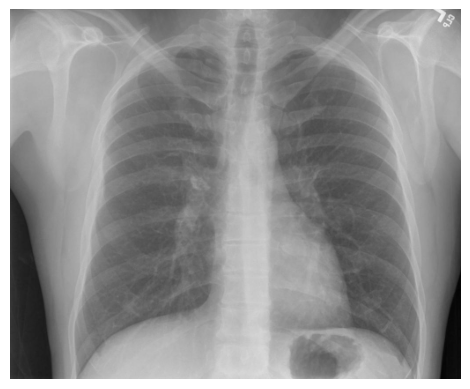

Generated report: Findings: the heart size. the lungs are normal.
Impression: .


In [32]:
report = trainer.robust_generate_radiology_report(
    image_input="/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1007_IM-0008-1001.png",
    max_tokens=100,
    temperature_range=(0.5, 1.5),
    deterministic=True,
    show_image=True
)
print("Generated report:", report)

In [33]:
from torch.utils.data import ConcatDataset, DataLoader
device = 'cuda' if torch.cuda.is_available() else 'cpu'
combined_dataset = ConcatDataset([val_dataset])
combined_loader = DataLoader(combined_dataset, batch_size=16, collate_fn=custom_collate_fn)


In [34]:
from PIL import Image
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import single_meteor_score
from rouge_score import rouge_scorer
from tqdm import tqdm
import pandas as pd
from nltk.tokenize import word_tokenize
def evaluate_dataloader_metrics_v2(dataloader, trainer, tokenizer, device, max_samples=None):
    results = []
    sample_count = 0
    smooth = SmoothingFunction()
    rouge = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    for batch in tqdm(dataloader, desc="Evaluating dataset"):
        input_ids = batch['input_ids']
        image_paths = batch['image_path']  # Ensure this exists and is batch-aligned

        for i in range(len(image_paths)):
            if max_samples and sample_count >= max_samples:
                break

            gt_input_ids = input_ids[i]
            if tokenizer.pad_token_id is not None:
                gt_input_ids = gt_input_ids[gt_input_ids != tokenizer.pad_token_id]
            reference_text = tokenizer.decode(gt_input_ids, skip_special_tokens=True)
            if not isinstance(reference_text, str) or len(reference_text.strip()) == 0:
                continue

            # Load image from the image path
            image_path = image_paths[i]
            pil_img = Image.open(image_path).convert('RGB')

            # Generate report from the image
            gen_report = trainer.robust_generate_radiology_report(
                pil_img,
                deterministic=True
            )

            # --- TOKENIZATION FOR METRICS ---
            ref_tokens = word_tokenize(reference_text)
            hyp_tokens = word_tokenize(gen_report)

            # BLEU scores for n = 1, 2, 3, 4
            bleu1 = sentence_bleu([ref_tokens], hyp_tokens, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
            bleu2 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
            bleu3 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
            bleu4 = sentence_bleu([ref_tokens], hyp_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth.method1)

            # METEOR (pass as strings, NOT as lists)
            meteor = single_meteor_score(ref_tokens, hyp_tokens)

            # ROUGE-L
            rouge_l_score = rouge.score(reference_text, gen_report)['rougeL'].fmeasure

            results.append({
                'BLEU-1': bleu1,
                'BLEU-2': bleu2,
                'BLEU-3': bleu3,
                'BLEU-4': bleu4,
                'METEOR': meteor,
                'ROUGE-L': rouge_l_score
            })
            sample_count += 1
            if max_samples and sample_count >= max_samples:
                break
        if max_samples and sample_count >= max_samples:
            break

    results_df = pd.DataFrame(results)
    avg_scores = results_df.mean().to_dict()
    return results_df, avg_scores

# --- Example usage ---
results_df, avg_scores = evaluate_dataloader_metrics_v2(test_loader, trainer, tokenizer, device)
print(results_df)
print('Average Scores:', avg_scores)


Evaluating dataset:   0%|          | 0/188 [00:00<?, ?it/s]You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Evaluating dataset: 100%|██████████| 188/188 [3:23:03<00:00, 64.80s/it]

        BLEU-1    BLEU-2    BLEU-3    BLEU-4    METEOR   ROUGE-L
0     0.044564  0.029513  0.019561  0.007486  0.110456  0.216216
1     0.011341  0.007443  0.004241  0.001804  0.095997  0.147059
2     0.044564  0.029513  0.019561  0.007486  0.110456  0.216216
3     0.044564  0.029513  0.019561  0.007486  0.110456  0.216216
4     0.067040  0.049194  0.036598  0.026653  0.167871  0.177778
...        ...       ...       ...       ...       ...       ...
1493  0.185760  0.035195  0.021550  0.016296  0.094937  0.086957
1494  0.209963  0.124371  0.031859  0.015773  0.262782  0.333333
1495  0.083060  0.043098  0.013423  0.007384  0.164817  0.190476
1496  0.002174  0.000798  0.000280  0.000163  0.047506  0.086957
1497  0.089252  0.045785  0.014137  0.007642  0.158298  0.172414

[1498 rows x 6 columns]
Average Scores: {'BLEU-1': 0.14799300471226173, 'BLEU-2': 0.08682966302879755, 'BLEU-3': 0.05026911130806933, 'BLEU-4': 0.0308757383657086, 'METEOR': 0.17719578021385937, 'ROUGE-L': 0.20949493674

In [35]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import random

def evaluate_on_val_samples(trainer, val_loader, tokenizer, num_samples=5):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Get a single batch from val_loader
    sample_batch = next(iter(val_loader))
    images = sample_batch['image']
    input_ids = sample_batch['input_ids']

    total_samples = min(num_samples, images.size(0))
    selected_indices = random.sample(range(images.size(0)), total_samples)

    for idx in selected_indices:
        # Get image tensor and decode ground truth report
        image_tensor = images[idx]
        ground_truth_ids = input_ids[idx]
        ground_truth_report = tokenizer.decode(ground_truth_ids, skip_special_tokens=True)

        # Reverse normalization for visualization
        image_disp = (image_tensor * std) + mean
        image_disp = transforms.ToPILImage()(image_disp)

        # Save image temporarily
        temp_path = "temp_image.png"
        image_disp.save(temp_path)

        # Generate report using your trainer
        generated_report = trainer.robust_generate_radiology_report(
            image_input=temp_path,
            max_tokens=100,
            temperature_range=(0.5, 1.5),
            deterministic=True,
            show_image=False  # We'll handle visualization here
        )

        # Plot image
        plt.figure(figsize=(6, 6))
        plt.imshow(image_disp)
        plt.axis('off')
        plt.title("Validation Sample Image")
        plt.show()

        # Display reports
        print(f"\n--- Ground Truth Report ---\n{ground_truth_report.strip()}")
        print(f"\n--- Generated Report ---\n{generated_report.strip()}")
        print("-" * 80)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


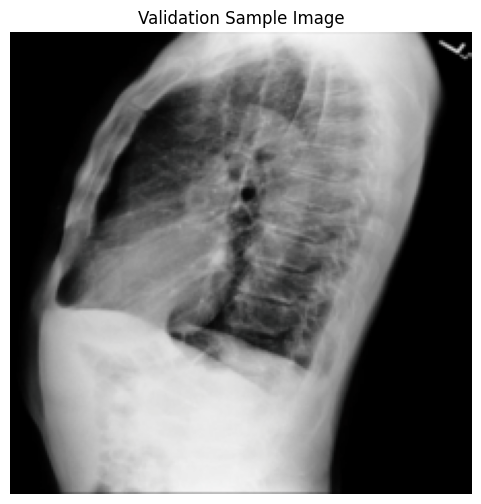


--- Ground Truth Report ---
heart size is at the upper limits of normal. there is aortic atherosclerotic vascular calcification. the lungs remain hyperexpanded. there are biapical opacities, stable from the prior study. no focal airspace consolidation. no significant pleural effusion. no pneumothorax. there are mild degenerative changes of the spine.  1. no focal airspace consolidation. 2. emphysema. 3. stable biapical opacities, possibly scarring.

--- Generated Report ---
Findings: the heart size. the lungs are normal.
Impression: .
--------------------------------------------------------------------------------


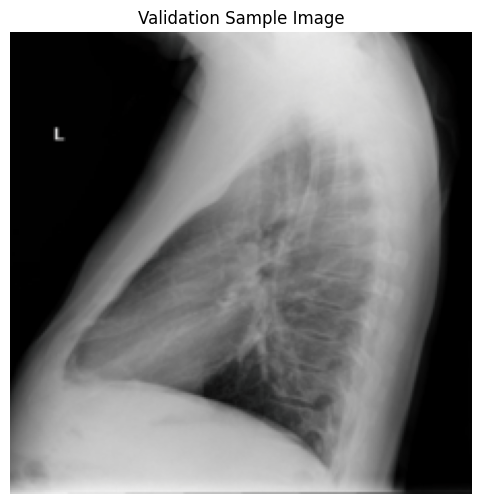


--- Ground Truth Report ---
the heart size and cardiopulmonary silhouette is normal. there is no focal airspace opacity, pleural effusion, or pneumothorax. the obstruction are intact with mild degenerative change in the thoracic spine.  no acute cardiopulmonary finding.

--- Generated Report ---
Findings: the heart size. the lungs are normal.
Impression: .
--------------------------------------------------------------------------------


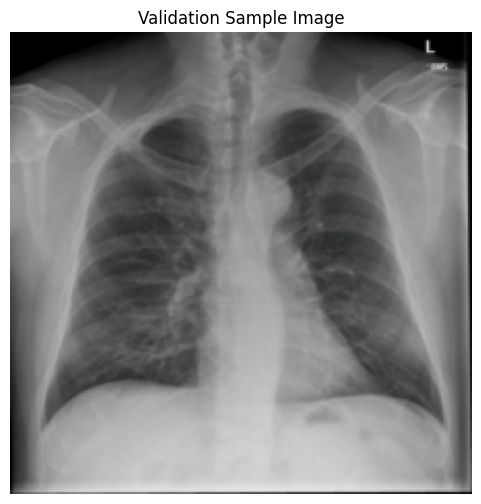


--- Ground Truth Report ---
the heart size and cardiopulmonary silhouette is normal. there is no focal airspace opacity, pleural effusion, or pneumothorax. the obstruction are intact with mild degenerative change in the thoracic spine.  no acute cardiopulmonary finding.

--- Generated Report ---
Findings: the heart size is normal. the lungs are normal.
Impression: no acute cardiopulmonary abnormality.
--------------------------------------------------------------------------------


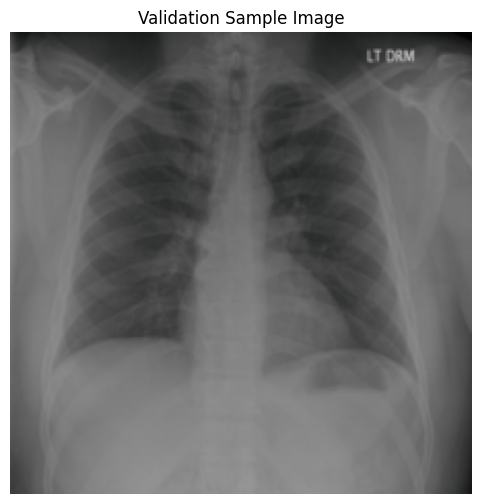


--- Ground Truth Report ---
frontal and lateral views of the chest demonstrate the cardiomediastinal silhouette normal. there is normal distribution of the pulmonary vascularity. the lungs are clear. no effusion, consolidation, or pneumothorax.  stable chest x-, without acute cardiopulmonary findings.

--- Generated Report ---
Findings: the heart size is normal. the lungs are normal.
Impression: no acute cardiopulmonary abnormality.
--------------------------------------------------------------------------------


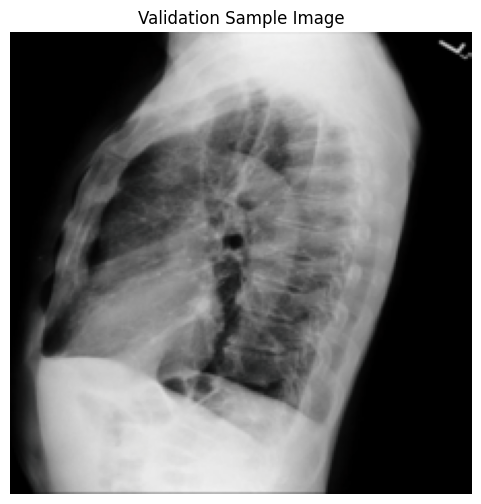


--- Ground Truth Report ---
heart size is at the upper limits of normal. there is aortic atherosclerotic vascular calcification. the lungs remain hyperexpanded. there are biapical opacities, stable from the prior study. no focal airspace consolidation. no significant pleural effusion. no pneumothorax. there are mild degenerative changes of the spine.  1. no focal airspace consolidation. 2. emphysema. 3. stable biapical opacities, possibly scarring.

--- Generated Report ---
Findings: the heart size is normal. the lungs are normal.
Impression: no acute cardiopulmonary abnormality.
--------------------------------------------------------------------------------


In [36]:
evaluate_on_val_samples(trainer, test_loader, tokenizer, num_samples=5)

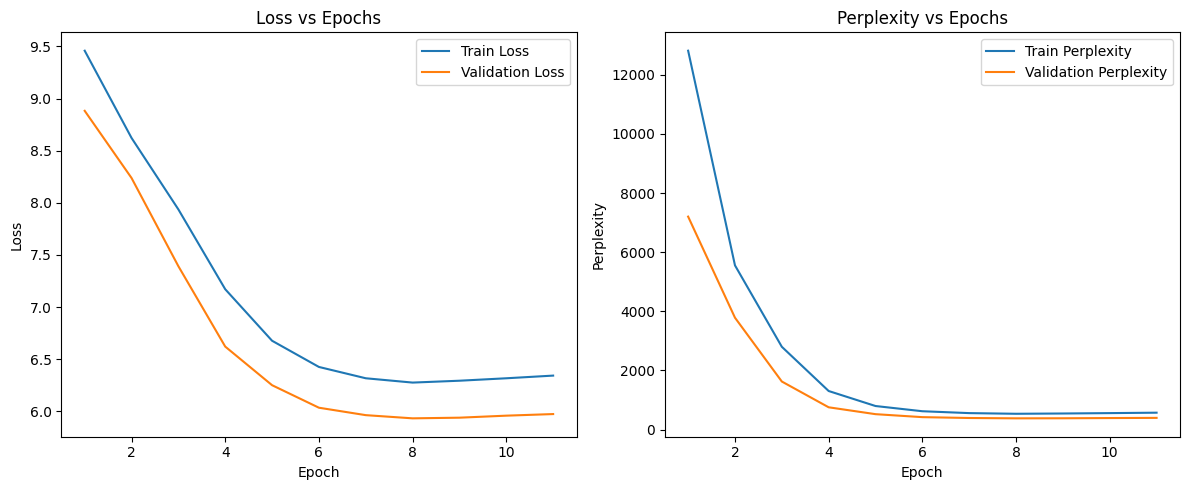

In [37]:
trainer.plot_loss_and_perplexity()